In [1]:
import numpy as np
import deepdish as dd
import time
import os, sys, importlib
#
import pso_bacco # https://github.com/hantke/pso_bacco
import GalaxyEmu
#
import cleaner

2025-05-14 16:33:43.636916: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 16:33:43.641074: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 16:33:43.713546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 16:33:44.453021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def ker_chi2(V1, V2):
    dV = (V2-V1)
    return  np.dot(dV,np.dot(CvI,dV))

def chi2(Param):# For vectorisation
    if len(stat) == 1:
        V1 = EmuArr[stat[0]].get_clustering(add_fix(Param), TF_decorator = True, target_r = r_arr[0])#[:,mask_arr[stat[0]]]#
    else:
        V1 = []
        for ii, i in enumerate(stat):
            V1.append(EmuArr[ii].get_clustering(add_fix(Param), TF_decorator = True, target_r = r_arr[ii]))
            if i == 4: V1[-1] =  V1[-1]/1e12 #CAREFULL LENSING NORMALISED!
        V1 = np.concatenate(V1,axis=1)
    _len = len(V1)
    __chi2 = np.empty(_len)
    for i in range(_len):
        __chi2[i] = ker_chi2(V1[i], target_vector)
        if np.isnan(__chi2[i]): __chi2[i] = 1e6

    return __chi2

def add_fix(param):
    for i in range(len(fix_prop)):
        param = np.insert(param, fix_prop[i][0], [fix_prop[i][1]],axis=1)
    return param

In [3]:
################ Create Raw Vector ################
def get_cosmo(cosmo):
    if cosmo == 'fix_Planck_Fl':
        return [[5, 0.807],[6, 0.3046],[7, 0.0486],[8, 0.967],[9, 0.681],[10, 0.06],[11, np.log10(target_n)],[12, target_z]]
    if cosmo == 'fix_Omb_ns_h_mnu_Fl':
        return [[7, 0.0486],[8, 0.967],[9, 0.681],[10, 0.06],[11, np.log10(target_n)],[12, target_z]]
    if cosmo == 'fix_Omb_ns_mnu_Fl':
        return [[7, 0.0486],[8, 0.967],[10, 0.06],[11, np.log10(target_n)],[12, target_z]] 
    if cosmo == 'fix_Planck':
        return [[5, 0.8159],[6, 0.3089],[7, 0.0486],[8, 0.9667],[9, 0.6774],[10, 0.0],[11, np.log10(target_n)],[12, target_z]]
    if cosmo == 'fix_Omb_ns_h_mnu':
        return [[7, 0.0486],[8, 0.9667],[9, 0.6774],[10, 0.0],[11, np.log10(target_n)],[12, target_z]]
    if cosmo == 'fix_Omb_ns_mnu':
        return [[7, 0.0486],[8, 0.9667],[10, 0.0],[11, np.log10(target_n)],[12, target_z]] 
    if cosmo == 'open':
        return [[11, np.log10(nden_arr)],[12, target_z]]

_zn = np.array([[3.2469e-02, 0.3064], [2.8350e-02, 0.4313], [2.1027e-02, 0.5744], [1.3542e-02, 0.7201], [9.6149e-03, 0.8848], [1.6299e-03, 1.3063]])

ibin = 1
cosmo = 'fix_Planck'
raw_data = np.loadtxt("data/w_rp_bin_%d.txt"%ibin, skiprows=1).T
rbins = np.logspace(-1,1.6,11) #Aproximate, ask for the real ones
target_n, target_z = _zn[ibin-1]

Arr = {}
Arr['Status'] = 'Raw'
Arr['Raw']    = {}
Arr['Clean']  = {}
Arr['Raw']['Cv']                = np.loadtxt("data/covariance_matrix_bin_%d.txt"%ibin)
Arr['Raw']['target_cluster']    = [raw_data[1],]
Arr['Raw']['r_arr']             = [raw_data[0],]
Arr['Raw']['rmin_wp']           = 0.1
Arr['Raw']['rmin_ds']           = 0.1
Arr['Raw']['rmax_wp']           = 40
Arr['Raw']['rmax_ds']           = 40
Arr['Raw']['stats']             = [0,]
Arr['Raw']['err_diag']          = 0.00
Arr['Raw']['diag']              = True
Arr['Raw']['output_name']       = 'Sample_%s_%d'%(cosmo, ibin)
Arr['Raw']['fix_prop']          = get_cosmo(cosmo)

In [4]:
###########
verbose        = True
###########
_input_data    = Arr
if _input_data['Status'] == 'Raw': input_data = cleaner.clean(_input_data)
else: input_data = _input_data

In [5]:
Cv            = input_data['Clean']['Cv']           
target_vector = input_data['Clean']['target_vector']
stat          = input_data['Clean']['stats']        
r_arr         = input_data['Clean']['r_arr'] 
output_name   = input_data['Clean']['output_name']  
bounds        = input_data['Clean']['bounds']
nprint        = input_data['Clean']['nprint']
fix_prop      = input_data['Clean']['fix_prop']
#
npoints          = input_data['Clean']['npoints']
niter            = input_data['Clean']['niter']
backup_frequency = input_data['Clean']['backup_frequency']
c1               = input_data['Clean']['c1']
c2               = input_data['Clean']['c2']
w                = input_data['Clean']['w']
reflect_param    = input_data['Clean']['reflect_param']
#
verbose       = input_data['Clean']['verbose']

In [6]:
CvI = np.linalg.inv(Cv)

In [7]:
EmuArr = []
for i in stat:
    EmuArr.append(GalaxyEmu.GalaxyEmu( emulator_ID = i, emulator_version=2, extra = '20Mpc'))

2025-05-14 16:33:45.048957: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
params = {'c1': c1, 'c2': c2, 'w': w}
pso = pso_bacco.pso_bacco.global_PSO(bounds = bounds, params = params, npoints=npoints,backup_name = output_name)#
pso.run(chi2, reflect_param = reflect_param,verbose=True, niter = niter,backup_name=output_name, backup_frequency=backup_frequency, vectorize=True)
#pso.save(filename)

Loading a backup in Sample_fix_Planck_1.
1/ 400    lower cost: 0.9242215519214735 best pos: [ 1.5953789  -0.70823735  1.46413538 -1.36217594  0.58913456]
2/ 400    lower cost: 0.9242215519214735 best pos: [ 1.5953789  -0.70823735  1.46413538 -1.36217594  0.58913456]
3/ 400    lower cost: 0.9242215519214735 best pos: [ 1.5953789  -0.70823735  1.46413538 -1.36217594  0.58913456]
4/ 400    lower cost: 0.9242215519214735 best pos: [ 1.5953789  -0.70823735  1.46413538 -1.36217594  0.58913456]
5/ 400    lower cost: 0.9242215519214735 best pos: [ 1.5953789  -0.70823735  1.46413538 -1.36217594  0.58913456]
6/ 400    lower cost: 0.9242214875649741 best pos: [ 1.59537743 -0.70825627  1.46413782 -1.36217992  0.58912832]
7/ 400    lower cost: 0.9242214875649741 best pos: [ 1.59537743 -0.70825627  1.46413782 -1.36217992  0.58912832]
8/ 400    lower cost: 0.9242214875649741 best pos: [ 1.59537743 -0.70825627  1.46413782 -1.36217992  0.58912832]
9/ 400    lower cost: 0.9242214875649741 best pos: [ 1.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import bacco
# bacco.plotting.set_FakeLatex(useTex=False)

target_vector
target_errors = np.sqrt(np.diag(Cv))#raw_data[2]
log_r = np.log10(r_arr[0])
GalaxyEmu_pred = EmuArr[0].get_clustering(add_fix([[0.9900806 ,  0.97095945 , 1.49999992 ,-1.49999941 , 0.47923557]]), TF_decorator = True, target_r = r_arr[0])[0]
#5#GalaxyEmu_pred = EmuArr[0].get_clustering(add_fix([[1.49846343, -1.14331022,  1.45838538, -1.499999 , 0.64882814]]), TF_decorator = True, target_r = r_arr[0])[0]
#4#GalaxyEmu_pred = EmuArr[0].get_clustering(add_fix([[1.5765153  , 0.8896048  , 1.49999977, -1.49999689 , 0.52477499]]), TF_decorator = True, target_r = r_arr[0])[0]
#3#GalaxyEmu_pred = EmuArr[0].get_clustering(add_fix([[1.79999766 , 0.21110406  ,1.49999923 ,-1.45325271 , 0.54929883]]), TF_decorator = True, target_r = r_arr[0])[0]
#2#GalaxyEmu_pred = EmuArr[0].get_clustering(add_fix([[1.79999847,  0.0275151 ,  1.4999973,  -1.42502003 , 0.52170081]]), TF_decorator = True, target_r = r_arr[0])[0]
#1#GalaxyEmu_pred = EmuArr[0].get_clustering(add_fix([[ 1.5953789 , -0.70823735 , 1.46413538, -1.36217594,  0.58913456]]), TF_decorator = True, target_r = r_arr[0])[0]

/lscratch/scontre/tmp/ipykernel_15122/620598329.py:11: RuntimeWarning: invalid value encountered in log10
  ax.errorbar(log_r, np.log10(target_vector), (np.log10(target_vector+target_errors) - np.log10(target_vector-target_errors))/2,c='k',marker='o', markersize=8,


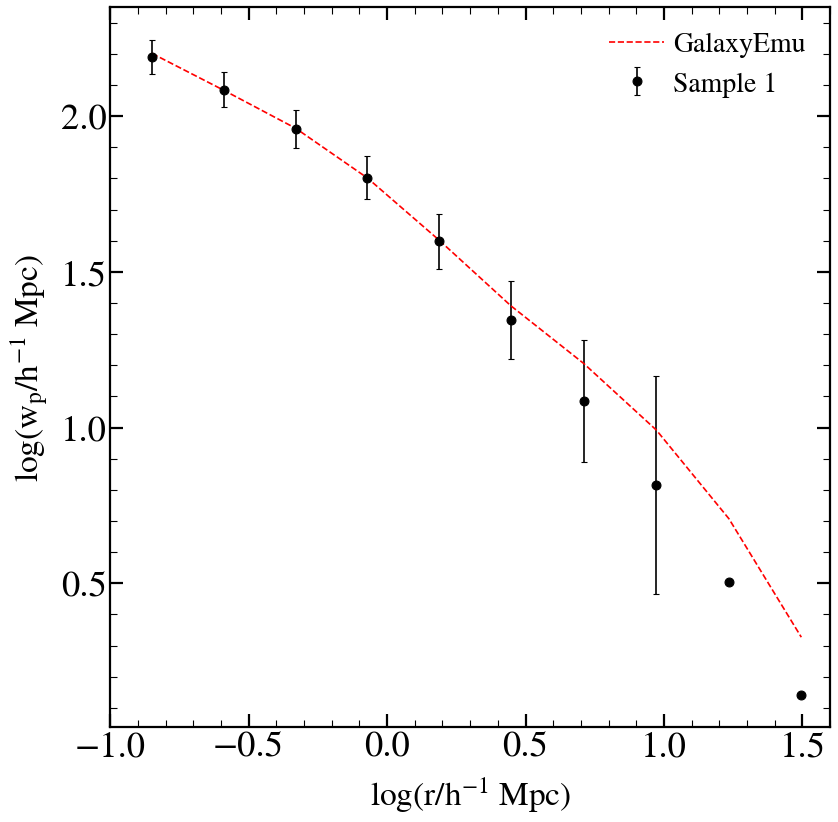

In [10]:
fig = plt.figure(figsize=(10,10))
xmin, xmax, ymin, ymax = -1,1.6,None,None

gs = gridspec.GridSpec(1,1, wspace=0.0, hspace=0.08)#, width_ratios=[1], height_ratios=[1]
ax = fig.add_subplot(gs[0])
ax.set_xlabel(r'$\rm log(r/h^{-1}\ Mpc)$', fontsize=30)
ax.set_ylabel(r'$\rm log(w_p/h^{-1}\ Mpc)$', fontsize=30)
ax.set_xlim([xmin,xmax])
#ax.set_ylim([ymin,ymax])

ax.errorbar(log_r, np.log10(target_vector), (np.log10(target_vector+target_errors) - np.log10(target_vector-target_errors))/2,c='k',marker='o', markersize=8,
            linestyle='none', capsize=3, label = 'Sample %d'%(ibin))

ax.plot(log_r, np.log10(GalaxyEmu_pred),'r--', label='GalaxyEmu')

ax.legend()
#plt.savefig('Real_Space_pk.pdf',rasterized=True,papertype = 'b10', bbox_inches='tight')